# Customer personal data protection

The task is to protect the data of customers of an insurance company. The task includes developing a data transformation method that will complicate recovering personal information from it, and to test it.

The quality of the machine learning models should not deteriorate during the transformation. The task doesn't include selection of the best model.

**Contents:** <br/>
<a href='#first'>1) Import the data</a> <br/>
<a href='#second'>2) Matrix multiplication (theory of the future transformation)</a> <br/>
<a href='#third'>3) Transformation algorithm</a> <br/>
<a href='#fourth'>4) Algorithm check </a> <br/>
<a href='#fifth'>5) Summary</a> <br/>

<a id='first'></a>
## 1. Import the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('/datasets/insurance.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [3]:
df = df.rename(columns = {'Пол':'Gender', 'Возраст':'Age', 'Зарплата':'Salary', 'Члены семьи':'Family_members', 'Страховые выплаты':'Insurance_payments' }) # renaming columns

,Gender,Age,Salary,Family_members,Insurance_payments
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Duplicates: 153


<AxesSubplot:>

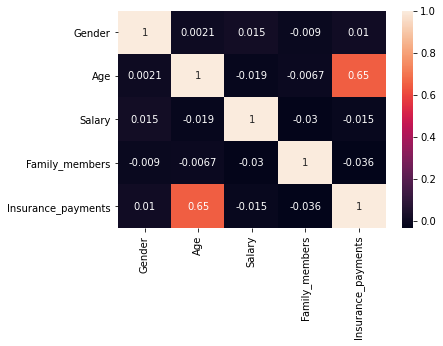

In [4]:
display(df.head())
print("Duplicates:", df.duplicated().sum())
sns.heatmap(df.corr(), annot=True)

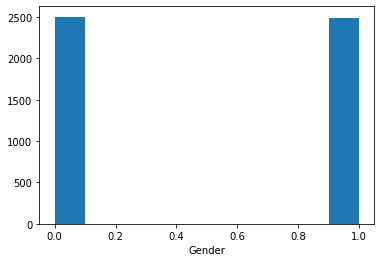

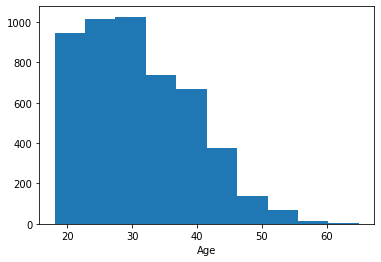

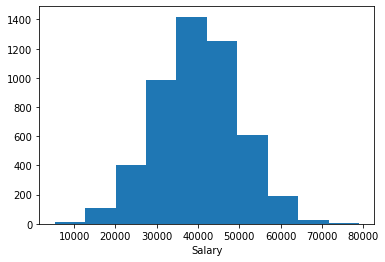

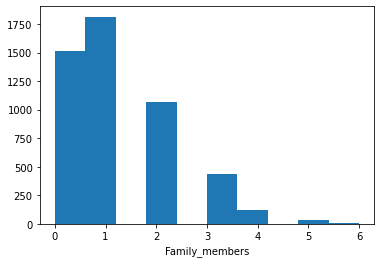

In [5]:
columns = ['Gender', 'Age', 'Salary', 'Family_members']
for column in columns:
    plt.hist(df[column])
    plt.xlabel(column)
    plt.show()
    print()

### Conclusion
The first step was dedicated to import and examining of the data file.<br/>
The data does not contain gaps, is converted to the correct data types. The multicollinearity is not an issue. The duplicates do exist, but as there is a small number of features, duplicates may take place and should not be removed. No further data preprocessing is required. <br/>

The dataset contains 5 columns:<br/>
`Gender` (1 or 0), `Age`, `Salary`, `Family members`
-> for further research are **feature (for learning)** <br/>

As expected, indicators of age and family members are distributed with a shift to the left (the number decreases with an increase in the value of the feature), while the feature of salary is distributed normally.

`Insurance payments` - the number of insurance payments for the last 5 years -> **target attribute**

<a id='second'></a>
## 2. Matrix multiplication (theory of the future transformation)

Symbols:

- $X$ - feature matrix (zero column consists of ones)

- $y$ — target feature vector

- $P$ is the matrix by which features are multiplied

- $w$ — vector of linear regression weights (zero element equals the shift)

Predictions:

$$
a = Xw
$$

Learning task:

$$
w = \arg\min_w MSE(Xw, y)
$$

Learning formula:

$$
w = (X^T X)^{-1} X^T y
$$

### Conclusion
**The quality of the linear regression will not change if to use formulas above.**

**Rationale:**

Let's apply feature multiplication by an invertible matrix:
X = xP
$$
w = ((xP)^T xP)^{-1} (xP)^T y 
$$

Let's apply the rules of matrix transposition:
$$
w = ((P^T)(x^T) xP)^{-1}  P^T x^T y
$$

Let's select square matrices and apply the inverse matrix rules:
1) (P^T) <br/>
2) x^Tx <br/>
3) P <br/>
$$
w = P^{-1} (x^Tx)^{-1} (P^T)^{-1}  P^T x^T y
$$
When multiplying an inverse matrix by a matrix, the identity matrix is obtained:
$$
(P^T)^{-1} P^T = E
$$

$$
w = P^{-1} (x^Tx)^{-1} E x^T y
$$
When multiplied by the identity matrix, the same matrix is obtained
$$
w = P^{-1} (x^Tx)^{-1} x^T y
$$


Then the prediction `a` will be:
$$
a = x P P^{-1} (x^Tx)^{-1} x^T y
$$
When multiplying an inverse matrix by a matrix, the identity matrix is obtained:
$$
P P^{-1} = E
$$

Thus, the prediction expression takes its original form:

$$
a = x E (x^Tx)^{-1} x^T y
$$
$$
a= xw
$$
$$
a = x (x^Tx)^{-1} x^T y
$$

<a id='third'></a>
## 3. Transformation algorithm

**Algorithm**

Following the conclusion from step 2, the features can be transformed by multiplying them by an invertible (square) matrix.

To do this, a normal square matrix using `np.random.normal` will be created. Then, the features will be multiplied by this matrix.

**Rationale**


In [6]:
features = df.drop('Insurance_payments',1)
target = df['Insurance_payments']

In [7]:
matrix = np.random.normal(1,100,(4,4))
features_matr = features.values@matrix
#comparison of model predictions calculated by the formula a=Xw
array_1 = (features.values@(np.linalg.inv(features.values.T.dot(features.values)).dot(features.values.T).dot(target))).round(2)
array_2 = (features_matr@(np.linalg.inv(features_matr.T.dot(features_matr)).dot(features_matr.T).dot(target))).round(2)
check=list(array_1==array_2)
np.unique(check, return_counts=True)

(array([ True]), array([5000]))

### Conclusion
Thus, the model data transformation algorithm to protect customer data was justified at this step. At the same time, the quality of the model remained unchanged, because predictions equal each other.
The algorithm will be programmed tn the next step, and the quality of the model will be checked.

<a id='fourth'></a>
## 4. Algorithm check

In [1]:
#Algorithm coding

def coded_data(features):
    def rnd_matrix(n):
        rand_matrix = np.random.normal(size=(n, n))
        try:
            np.linalg.inv(rand_matrix)
        except LinAlgError:
            rnd_matrix(n)
        return rand_matrix
    
    coded_features = features.values @ rnd_matrix(4)
    return(coded_features)

In [9]:
features_1 = coded_data(features)

display(features.head(3), features.tail(3))
display(features_1) #check

,Gender,Age,Salary,Family_members
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0


,Gender,Age,Salary,Family_members
4997,0,20.0,33900.0,2
4998,1,22.0,32700.0,3
4999,1,28.0,40600.0,1


array([[-24048.96121466,  -2489.49894066, -13575.49423396,
        -63776.29521775],
       [-18434.03690009,  -1918.35316139, -10415.87617063,
        -48877.46806243],
       [-10189.75493387,  -1062.24755299,  -5760.59451323,
        -27015.91961862],
       ...,
       [-16430.77257636,  -1696.86609754,  -9268.27464755,
        -43576.76325047],
       [-15851.06130877,  -1639.85553211,  -8942.00573109,
        -42040.0097536 ],
       [-19681.54130217,  -2033.82593726, -11106.05555376,
        -52197.31486705]])

In [10]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=12345
)

model = LinearRegression()
model.fit(features_train, target_train)
r2_before = r2_score(target_valid, model.predict(features_valid))
print(f"Metrics before transformation: {r2_before:,.4f}.")

Metrics before transformation: 0.4352.


In [11]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1,
    target,
    test_size=0.25,
    random_state=12345
)

model.fit(features_train_1, target_train_1)
r2_after = r2_score(target_valid_1, model.predict(features_valid_1))
print(f"Metrics after transformation: {r2_after:,.4f}.")

Metrics after transformation: 0.4352.


In [12]:
print(f"R2 diff as of before and after transformation: {(r2_after-r2_before):,.4f}.")

R2 diff as of before and after transformation: -0.0000.


<a id='fifth'></a>
## 5. Summary
Thus, the linear regression quality metric R2 did not change due to the feature transformation and remained at the level of **0.4352**.
The quality of the model is the same before and after the transformation.